# PREPARATION

In [79]:
import pandas as pd
df = pd.read_csv("run/accuracy/datasets/fever_with_evidence_5.csv")
df.columns

Index(['Unnamed: 0', 'label', 'claim', 'evidence_1', 'evidence_2',
       'evidence_3', 'evidence_4', 'gemma-2-2b-it', 'Mistral-7B-Instruct',
       'gemma-3-1b-it', 'gemma-3-4b-it', 'gemma-3-270m-it',
       'Qwen/Qwen2.5-1.5B-Instruct', 'Qwen/Qwen2.5-3B-Instruct'],
      dtype='object')

In [80]:
len(df)

22682

In [81]:
df.loc[22681, 'label']

'REFUTES'

In [82]:
from typing import Any
import math

UNIQUE_LABELS = ["NOT ENOUGH INFO", "SUPPORTS", "REFUTES"]
NUM_TRIALS = 10
GAP = 1
ALPHA = 0.35
INDICES = list(range(len(df)))
MODELS = ['gemma-2-2b-it', 'Mistral-7B-Instruct',
       'gemma-3-1b-it', 'gemma-3-4b-it', 'gemma-3-270m-it',
       'Qwen/Qwen2.5-1.5B-Instruct', 'Qwen/Qwen2.5-3B-Instruct']
SHORT_NAMES = {
    'gemma-2-2b-it': '2b', 'Mistral-7B-Instruct': '7b',
       'gemma-3-1b-it': '1b', 'gemma-3-4b-it': '4b', 'gemma-3-270m-it': '270m',
       'Qwen/Qwen2.5-1.5B-Instruct': '1.5b', 'Qwen/Qwen2.5-3B-Instruct': '3b'
}
NUM_LLMS = len(MODELS)
ACC = {}
for model in MODELS:
    ACC[model] =(df["label"] == df[model]).sum()
ACC

{'gemma-2-2b-it': 10259,
 'Mistral-7B-Instruct': 11892,
 'gemma-3-1b-it': 7974,
 'gemma-3-4b-it': 11277,
 'gemma-3-270m-it': 6683,
 'Qwen/Qwen2.5-1.5B-Instruct': 9332,
 'Qwen/Qwen2.5-3B-Instruct': 10955}

# UNWEIGHTED VOTING

In [83]:

# unweighted voting
def most_votes_win(df) -> int:
    """Returns accuracy based on unweighted voting."""
    correct = 0
    for _, row in df.iterrows():
        votes = {label: 0 for label in UNIQUE_LABELS}
        for model in MODELS:
            prediction = row[model]
            votes[prediction] += 1
        # Find label with most votes
        winning_label = max(votes, key=votes.get)
        if winning_label == row['label']:
            correct += 1
    return correct
ACC["unweighted"] = most_votes_win(df)
display(ACC["unweighted"])


10433

# WEIGHTED VOTING + DISAGREEMENT-BASED SAMPLE SELECTION

In [84]:
def plot_weight_and_accuracy(weight_evolution: list[list[float]], models: list[str], accuracies: dict) -> None:
    import matplotlib.pyplot as plt

    if not weight_evolution:
        raise ValueError("weight_evolution is empty")

    # Transpose → each entry is weight history for one model
    per_model_weights = list(zip(*weight_evolution))

    plt.figure(figsize=(8, 5))

    for model, weights in zip(models, per_model_weights):
        acc = accuracies[model]
        plt.plot(weights, label=f"{SHORT_NAMES[model]} (acc={acc})")

    plt.xticks(range(len(weight_evolution)), [i * GAP for i in range(len(weight_evolution))])
    plt.xlabel("Trial")
    plt.ylabel("Weight")
    plt.title("Weight Evolution with Final Accuracies")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [85]:
def mwu(df: pd.DataFrame, 
        index_range: list, 
        num_sams: int = 10, 
        alpha: float = 0.35, ) -> list[list[float]]:
    """Returns weight evolution based on Hedge rule"""
    weights = [1.] * NUM_LLMS

    weight_evolution = [weights.copy()]

    for _ in range(1, num_sams+1):
        # disagreement-based sample selection
        minimax_load: int = NUM_LLMS + 1  # init above range
        best_index: int = len(df) # init out of range
        for index in index_range:
            row = df.iloc[index]
            votes = {label: 0. for label in UNIQUE_LABELS}
            for model_index, model in enumerate(MODELS):
                prediction = row[model]
                votes[prediction] += weights[model_index]
            # Find label with most votes
            winning_label = max(votes, key=votes.get)
            cur_max_load = votes[winning_label]
            # update best if current is better
            if cur_max_load < minimax_load:
                minimax_load = cur_max_load
                best_index = index

        # Update weights based on best_index
        best_row = df.iloc[best_index]
        for model_index, model in enumerate(MODELS):
            prediction = best_row[model]
            if prediction != best_row['label']:
                weights[model_index] *= math.exp(-alpha)
        
        # track weight evolution
        weight_evolution.append(weights.copy())

        # Remove best_index from index_range
        index_range.remove(best_index)
    return weight_evolution, weights

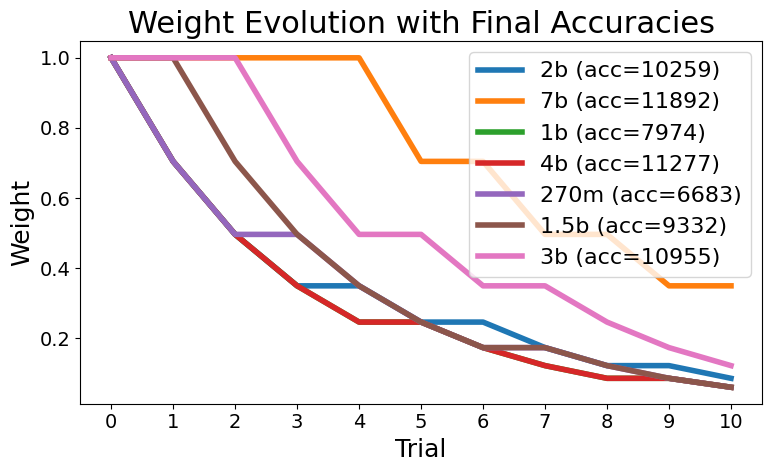

In [86]:
weight_evolution_disagreement, final_weights_disagreement = mwu(df, INDICES.copy(), NUM_TRIALS, ALPHA)
plot_weight_and_accuracy(weight_evolution_disagreement, MODELS, ACC)

In [87]:

wdict_disagreement: dict = {}
for model, weight in zip(MODELS, final_weights_disagreement):
    wdict_disagreement[model] = weight
wdict_disagreement

{'gemma-2-2b-it': 0.08629358649937052,
 'Mistral-7B-Instruct': 0.3499377491111554,
 'gemma-3-1b-it': 0.06081006262521797,
 'gemma-3-4b-it': 0.06081006262521797,
 'gemma-3-270m-it': 0.06081006262521797,
 'Qwen/Qwen2.5-1.5B-Instruct': 0.06081006262521797,
 'Qwen/Qwen2.5-3B-Instruct': 0.12245642825298192}

In [88]:
# weighted voting 
def weighted_voting(df, wdict: dict[str, float]) -> int:
    """Returns accuracy based on unweighted voting."""
    correct = 0
    for _, row in df.iterrows():
        votes = {label: 0 for label in UNIQUE_LABELS}
        for model in MODELS:
            prediction = row[model]
            votes[prediction] += wdict[model]
        # Find label with most votes
        winning_label = max(votes, key=votes.get)
        if winning_label == row['label']:
            correct += 1
    return correct

In [89]:
ACC["weighted_disagreement"] = weighted_voting(df, wdict_disagreement)
display(ACC["weighted_disagreement"])

12139

# WEIGHTED VOTING + RANDOM SAMPLES

In [90]:
import random
random.seed(10)

def mwu_random_samples(df: pd.DataFrame, 
        index_range: list, 
        num_sams: int = 10, 
        alpha: float = 0.35, ) -> list[list[float]]:
    """Returns weight evolution based on Hedge rule"""
    weights = [1.] * NUM_LLMS

    weight_evolution = [weights.copy()]

    for _ in range(1, num_sams+1):
        chosen_index = random.choice(index_range)

        # Update weights based on best_index
        chosen_row = df.iloc[chosen_index]
        for model_index, model in enumerate(MODELS):
            prediction = chosen_row[model]
            if prediction != chosen_row['label']:
                weights[model_index] *= math.exp(-alpha)
        
        # track weight evolution
        weight_evolution.append(weights.copy())

        # Remove best_index from index_range
        index_range.remove(chosen_index)
    return weight_evolution, weights

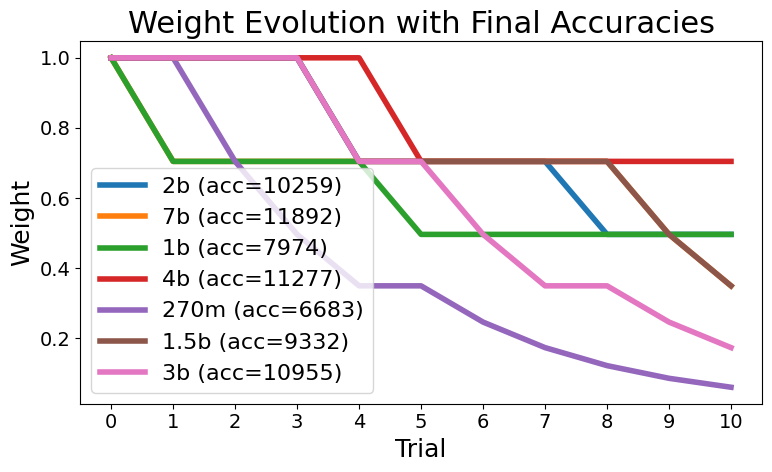

10952

In [91]:
weight_evolution_rand, final_weights_rand = mwu_random_samples(df, INDICES.copy(), NUM_TRIALS, ALPHA)
# final weights dict
wdict_rand = {}
for model, weight in zip(MODELS, final_weights_rand):
    wdict_rand[model] = weight

plot_weight_and_accuracy(weight_evolution_rand, MODELS, ACC)
ACC["weighted_random"] = weighted_voting(df, wdict_rand)
display(ACC["weighted_random"])

# WEIGHTED VOTING + VARIANCE of DISAGREEMENT-BASED SAMPLE SELECTION

In [92]:
def mwu_variant(df: pd.DataFrame, 
        index_range: list, 
        num_sams: int = 10, 
        alpha: float = 0.35, ) -> list[list[float]]:
    """Returns weight evolution based on Hedge rule"""
    weights = [1.] * NUM_LLMS

    weight_evolution = [weights.copy()]

    for _ in range(1, num_sams+1):
        minimax_load: int = NUM_LLMS + 1  # init above range
        best_index: int = len(df) # init out of range
        for index in index_range:
            row = df.iloc[index]
            votes = {label: 0. for label in UNIQUE_LABELS}
            for model_index, model in enumerate(MODELS):
                prediction = row[model]
                votes[prediction] += 1 # changed line
                # votes[prediction] += weights[model_index] --- IGNORE ---
            # Find label with most votes
            winning_label = max(votes, key=votes.get)
            cur_max_load = votes[winning_label]
            # update best if current is better
            if cur_max_load < minimax_load:
                minimax_load = cur_max_load
                best_index = index

        # Update weights based on best_index
        best_row = df.iloc[best_index]
        for model_index, model in enumerate(MODELS):
            prediction = best_row[model]
            if prediction != best_row['label']:
                weights[model_index] *= math.exp(-alpha)
        
        # track weight evolution
        weight_evolution.append(weights.copy())

        # Remove best_index from index_range
        index_range.remove(best_index)
    return weight_evolution, weights

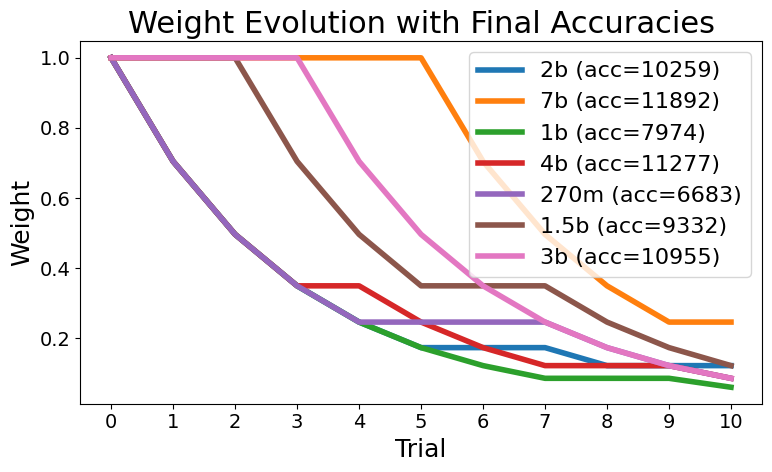

11624

In [93]:
weight_evolution_variant, final_weights_variant = mwu_variant(df, INDICES.copy(), NUM_TRIALS, ALPHA)
# final weights dict
wdict_variant = {}
for model, weight in zip(MODELS, final_weights_variant):
    wdict_variant[model] = weight

plot_weight_and_accuracy(weight_evolution_variant, MODELS, ACC)
ACC["weighted_variant"] = weighted_voting(df, wdict_variant)
display(ACC["weighted_variant"])

# FINAL TOUCH

In [94]:
heaviest_rand = max(wdict_rand, key=wdict_rand.get)
ACC[heaviest_rand]


11277

In [95]:
heaviest_disagreement = max(wdict_disagreement, key=wdict_disagreement.get)
ACC[heaviest_disagreement]

11892

In [96]:
ACC

{'gemma-2-2b-it': 10259,
 'Mistral-7B-Instruct': 11892,
 'gemma-3-1b-it': 7974,
 'gemma-3-4b-it': 11277,
 'gemma-3-270m-it': 6683,
 'Qwen/Qwen2.5-1.5B-Instruct': 9332,
 'Qwen/Qwen2.5-3B-Instruct': 10955,
 'unweighted': 10433,
 'weighted_disagreement': 12139,
 'weighted_random': 10952,
 'weighted_variant': 11624}

In [130]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_improvement(methods: list[str], accuracy: list[int]):
    # PowerPoint-friendly style settings
    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.size": 16,
        "axes.titlesize": 22,
        "axes.labelsize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "lines.linewidth": 4,
    })

    df = pd.DataFrame({"Method": methods, "Accuracy": accuracy})

    plt.figure(figsize=(12, 6))

    # Use a strong PowerPoint-friendly color
    plt.plot(
        df["Method"],
        df["Accuracy"],
        marker="o",
        markersize=12,
        color="#1f77b4",       # clean blue
    )

    # Label each point clearly
    for x, y in zip(df["Method"], df["Accuracy"]):
        if y == accuracy[-1]:
            plt.text(x, y - (max(accuracy) * 0.01), f"{y:,}", ha="center", fontsize=14, va="top")
        else:
            plt.text(x, y + (max(accuracy) * 0.01), f"{y:,}", ha="center", fontsize=14, va="bottom")

    plt.title("Correctness Improvement", fontweight="bold")
    plt.ylabel("correct answers")

    plt.yticks([])

    # Clean, subtle grid
    plt.grid(True, linestyle="--", alpha=0.25)
    # for spine in ["top", "right", "left", "bottom"]:
    #     plt.gca().spines[spine].set_visible(False)

    # Extra spacing for PowerPoint export
    plt.xticks(rotation=25, ha="right")
    plt.gcf().subplots_adjust(top=0.88, bottom=0.22)
    plt.tight_layout()
    plt.show()


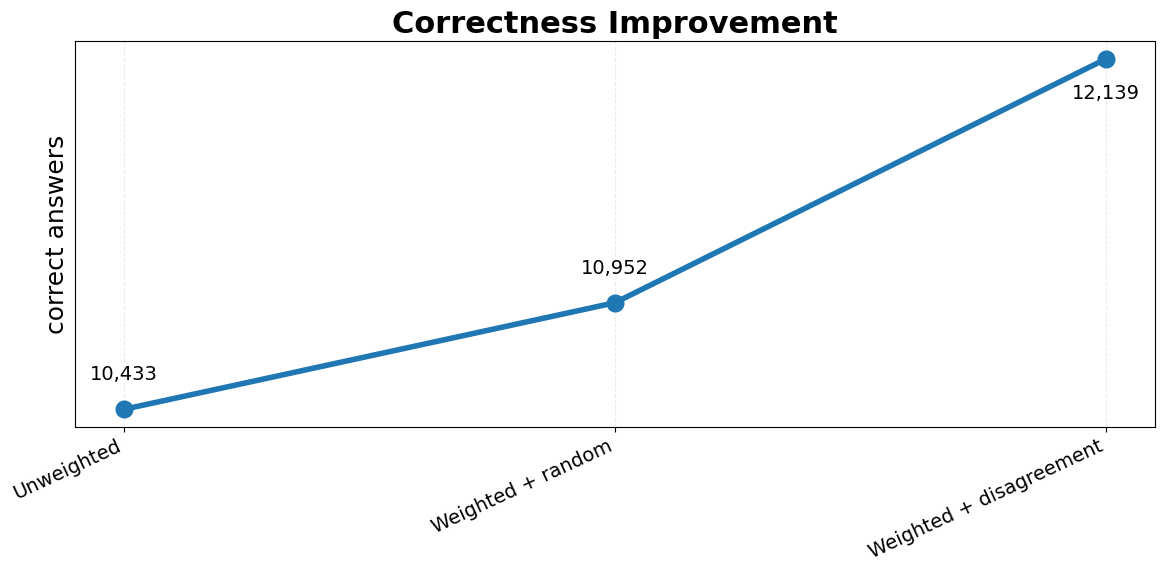

In [131]:

methods = [
    "Unweighted",
    "Weighted + random",
    # "Heaviest + random",
    # "Heaviest + disagreement",
    "Weighted + disagreement",
]

accuracy = [
    ACC["unweighted"],
    ACC["weighted_random"],
    # ACC[heaviest_rand],
    # ACC[heaviest_disagreement],
    ACC["weighted_disagreement"]
]

plot_improvement(methods, accuracy)


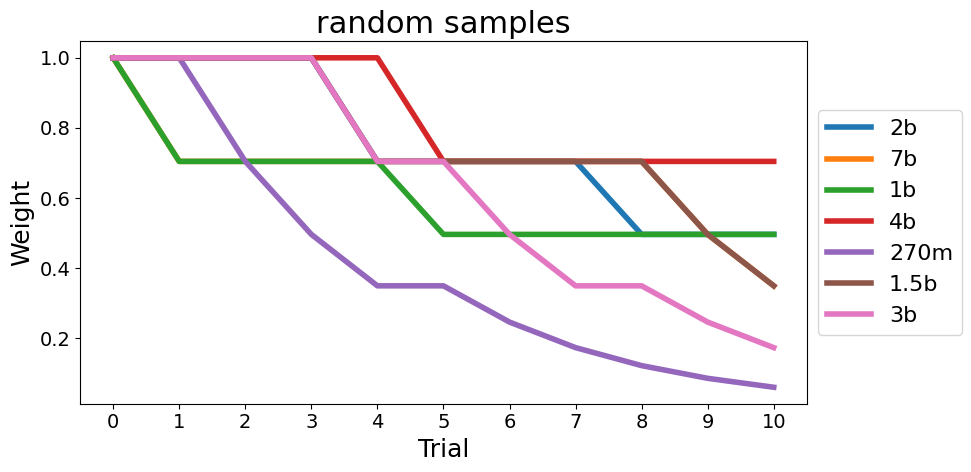

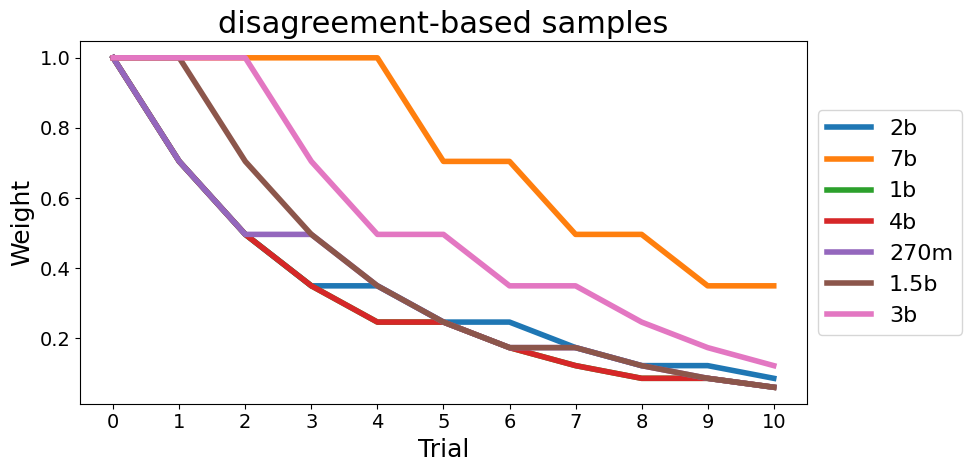

In [132]:
def plot_weight_evolution(weight_evolution: list[list[float]], models: list[str], subtitle: str) -> None:
    import matplotlib.pyplot as plt

    if not weight_evolution:
        raise ValueError("weight_evolution is empty")

    # Transpose → each entry is weight history for one model
    per_model_weights = list(zip(*weight_evolution))

    plt.figure(figsize=(10, 5))
    # plt.figure(figsize=(12, 6))

    for model, weights in zip(models, per_model_weights):
        plt.plot(weights, label=f"{SHORT_NAMES[model]}")

    plt.xticks(range(len(weight_evolution)), [i * GAP for i in range(len(weight_evolution))])
    plt.xlabel("Trial")
    plt.ylabel("Weight")
    # plt.title("Weight Evolution")
    plt.title(subtitle)

    plt.legend(
    loc="center left",       # place legend to the right
    bbox_to_anchor=(1, 0.5), # anchor to middle right outside the axes
    frameon=True
    )
    plt.tight_layout()
    plt.show()


plot_weight_evolution(weight_evolution_rand, MODELS, subtitle = "random samples")
plot_weight_evolution(weight_evolution_disagreement, MODELS, subtitle = "disagreement-based samples")

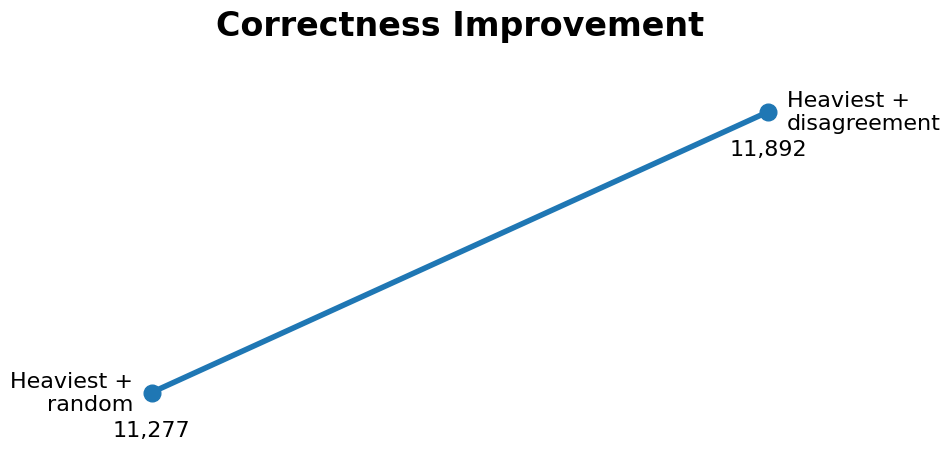

In [133]:
import matplotlib.pyplot as plt

correct_heaviest_rand = ACC[heaviest_rand]           # 11277
correct_heaviest_dis = ACC[heaviest_disagreement]    # 11892

x = [0, 1]
y = [correct_heaviest_rand, correct_heaviest_dis]

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 16,
    "axes.titlesize": 24,
    "axes.labelsize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

plt.figure(figsize=(10, 5))

# main line
plt.plot(x, y, marker="o", markersize=12, linewidth=4, color="#1f77b4")

# remove x-axis ticks and spine for a cleaner slope-chart look
plt.xticks([])
plt.xlim(-0.2, 1.2)

# tighten y-range to emphasize improvement
padding = 150
plt.ylim(min(y) - padding, max(y) + padding)

# plt.ylabel("Correct answers")
plt.title("Correctness Improvement", fontweight="bold")

# method labels left & right of points
plt.text(
    x[0] - 0.03, y[0],
    "Heaviest +\nrandom",
    ha="right", va="center"
)
plt.text(
    x[1] + 0.03, y[1],
    "Heaviest +\ndisagreement",
    ha="left", va="center"
)

# value labels just below the dots
for xi, yi in zip(x, y):
    plt.text(
        xi, yi - 60,
        f"{yi:,}",
        ha="center", va="top"
    )

# annotate the gain
# delta = correct_heaviest_dis - correct_heaviest_rand
# plt.annotate(
#     f"+{delta:,} correct answers",
#     xy=(x[1], y[1]),
#     xytext=(0.5, y[0] + 120),
#     ha="center",
#     arrowprops=dict(arrowstyle="->", lw=2)
# )

plt.yticks([])
plt.grid(axis="y", linestyle="--", alpha=0.25)

for spine in ["top", "right", "left", "bottom"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()
